# Global (Imports, Constants, Utils etc) 



## GPU type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 23 14:26:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 33%   36C    P8    20W / 170W |    727MiB / 12045MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [3]:
import os
import sys
import random
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer



## Constant definision

In [4]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)


MAGNOMETER_SENSORS = [ "magnetometer_magnetic_field_body_x",
                      "magnetometer_magnetic_field_body_y", 
                      "magnetometer_magnetic_field_body_z"]
BOROMETER_SENSORS = ["barometer_altitude", "barometer_pressure"]
ROTOR_SPEEDS = ["rotor_a_speed", "rotor_b_speed", "rotor_c_speed", "rotor_d_speed"]
ACCELOMETER_SENSORS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                       "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                       "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                       "angular_velocity_x", "angular_velocity_y", "angular_velocity_z"]

ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
ANGULAR_VELOCITY_SENSORS = ["angular_velocity_x", "angular_velocity_y"]
LINEAR_ACCELERATION_SENSORS = ["linear_acceleration_x", "linear_acceleration_y"]
ANGULAR_ACCELERATION_SENSORS = [ "angular_acceleration_x", "angular_acceleration_y"]

INPUT_COLUMNS = [*ORIENTATION_SENSORS, *LINEAR_ACCELERATION_SENSORS]

OUTPUT_COLUMNS = ["linear_velocity_x", "linear_velocity_y"]


In [5]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)
    random.shuffle(all_csv_files)

    # Orders the "manual" files to the end (They are more likely represent 
    # the test user). So this data should be used as test
    # auto_genereted_flights = [recording_file for recording_file in all_csv_files 
    #                           if not recording_file.startswith("manual")]
    # manual_generated_flights = [recording_file for recording_file in all_csv_files 
    #                           if recording_file.startswith("manual_2022:04:22_20:34:20_record.csv")]
    all_csv_files.remove("manual_2022:04:22_20:38:48_record.csv")
    all_csv_files.append("manual_2022:04:22_20:38:48_record.csv")

    return all_csv_files


In [6]:
# Set float 64
tf.keras.backend.set_floatx('float32')

## Utils


### Save and Load models

In [7]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

In [8]:

def ewma_vectorized_safe(data, alpha, row_size=None, dtype=None, order='C', out=None):
    """
    Reshapes data before calculating EWMA, then iterates once over the rows
    to calculate the offset without precision issues
    :param data: Input data, will be flattened.
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param row_size: int, optional
        The row size to use in the computation. High row sizes need higher precision,
        low values will impact performance. The optimal value depends on the
        platform and the alpha being used. Higher alpha values require lower
        row size. Default depends on dtype.
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the desired output. If not provided or `None`,
        a freshly-allocated array is returned.
    :return: The flattened result.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float
    else:
        dtype = np.dtype(dtype)

    row_size = int(row_size) if row_size is not None \
               else get_max_row_size(alpha, dtype)

    if data.size <= row_size:
        # The normal function can handle this input, use that
        return ewma_vectorized(data, alpha, dtype=dtype, order=order, out=out)

    if data.ndim > 1:
        # flatten input
        data = np.reshape(data, -1, order=order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    row_n = int(data.size // row_size)  # the number of rows to use
    trailing_n = int(data.size % row_size)  # the amount of data leftover
    first_offset = data[0]

    if trailing_n > 0:
        # set temporary results to slice view of out parameter
        out_main_view = np.reshape(out[:-trailing_n], (row_n, row_size))
        data_main_view = np.reshape(data[:-trailing_n], (row_n, row_size))
    else:
        out_main_view = out
        data_main_view = data

    # get all the scaled cumulative sums with 0 offset
    ewma_vectorized_2d(data_main_view, alpha, axis=1, offset=0, dtype=dtype,
                       order='C', out=out_main_view)

    scaling_factors = (1 - alpha) ** np.arange(1, row_size + 1)
    last_scaling_factor = scaling_factors[-1]

    # create offset array
    offsets = np.empty(out_main_view.shape[0], dtype=dtype)
    offsets[0] = first_offset
    # iteratively calculate offset for each row
    for i in range(1, out_main_view.shape[0]):
        offsets[i] = offsets[i - 1] * last_scaling_factor + out_main_view[i - 1, -1]

    # add the offsets to the result
    out_main_view += offsets[:, np.newaxis] * scaling_factors[np.newaxis, :]

    if trailing_n > 0:
        # process trailing data in the 2nd slice of the out parameter
        ewma_vectorized(data[-trailing_n:], alpha, offset=out_main_view[-1, -1],
                        dtype=dtype, order='C', out=out[-trailing_n:])
    return out


## Data Split

In [9]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


### Shuffle dataset

In [10]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load data

In [11]:
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)
    
    x_df = flight_df[input_columns].copy()

    next_df = x_df[ORIENTATION_SENSORS].shift(-1)
    orientaion_diff = (next_df - x_df[ORIENTATION_SENSORS])
    orientaion_diff.rename(columns={key : f"{key}_diff" for key in orientaion_diff.columns}, inplace=True)

    y_df = flight_df[output_columns].copy()
    

    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    x_df = pd.concat([x_df, orientaion_diff[:-1]], axis=1)

    return x_df, y_df

In [12]:
def load_dataset(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df)
            y_sessions.append(y_df)

        except ValueError as error:
            print(str(error))

    x_df = pd.concat(x_sessions, ignore_index=True)
    y_df = pd.concat(y_sessions, ignore_index=True)

    return x_df, y_df


### Preprocess data

In [13]:
def preprocess_ann_dataset(x_df: pd.DataFrame, y_df : pd.DataFrame):
    scaler_y = MinMaxScaler()
    scaler_x = MinMaxScaler((-1,1))
    # scaler_x = MinMaxScaler()

    data_x = scaler_x.fit_transform(x_df)
    data_y = y_df.to_numpy()
    data_y = scaler_y.fit_transform(data_y)

    data_x = data_x.astype(np.float32)
    data_y = data_y.astype(np.float32)

    return data_x, data_y, scaler_x, scaler_y

In [14]:
def load_preprocessed_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_df, y_df = load_dataset(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_ann_dataset(x_df, y_df)

    train_x, dev_x, test_x = split_data(x_data, train_per=0.9, dev_per=0.1)
    train_y, dev_y, test_y = split_data(y_data, train_per=0.9, dev_per=0.1)

    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

# Feature Analysis

In [15]:
x_df, y_df = load_dataset(INPUT_COLUMNS, OUTPUT_COLUMNS)

## Visualization

In [16]:
record_file_name = "manual_2022:04:22_20:38:48_record.csv"      
record_file_path = os.path.join(DATA_FOLDER_PATH, record_file_name)
x_df, y_df = load_flight_steps_from_file(record_file_path, INPUT_COLUMNS, OUTPUT_COLUMNS)

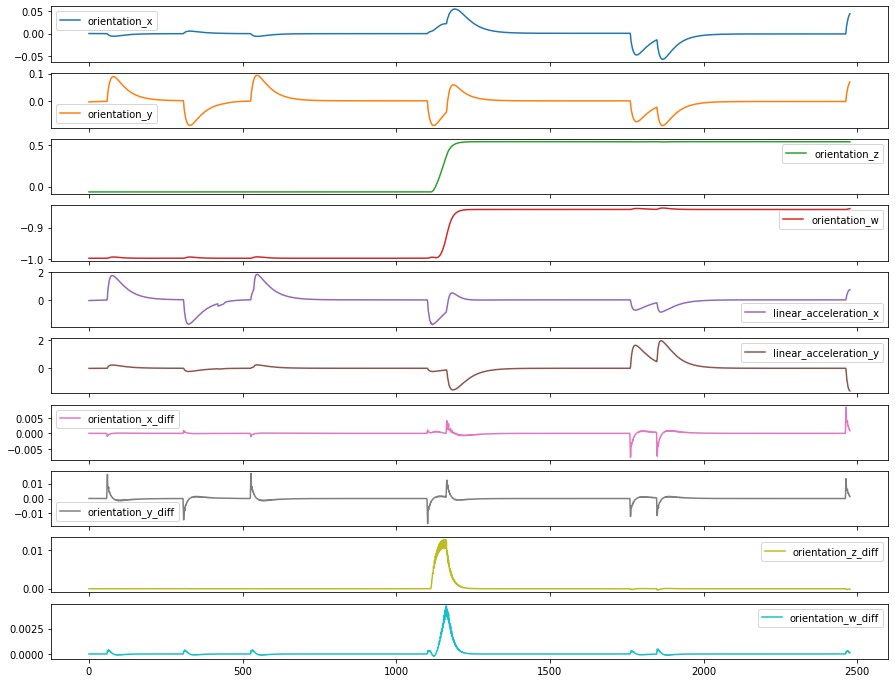

In [17]:
otuput = x_df.plot(subplots=True, figsize=(15,12))

###### Plot

All Columns plot


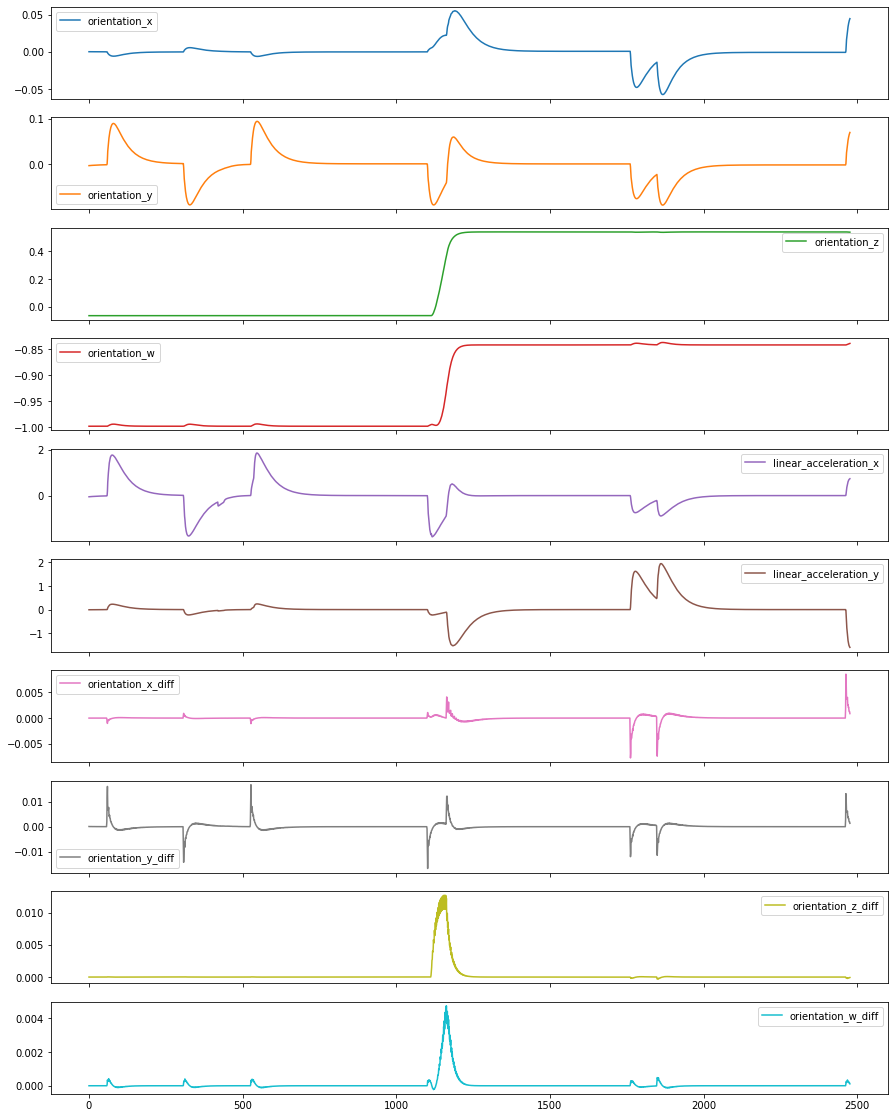

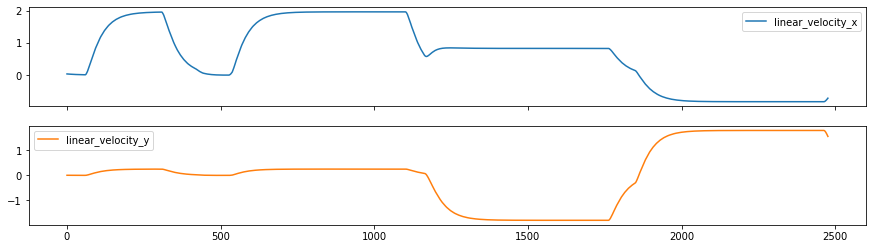

In [18]:
print("All Columns plot")
otuput = x_df.plot(subplots=True, figsize=(15,20))
otuput = y_df.plot(subplots=True, figsize=(15,4))

###### Hist

All Columns plot


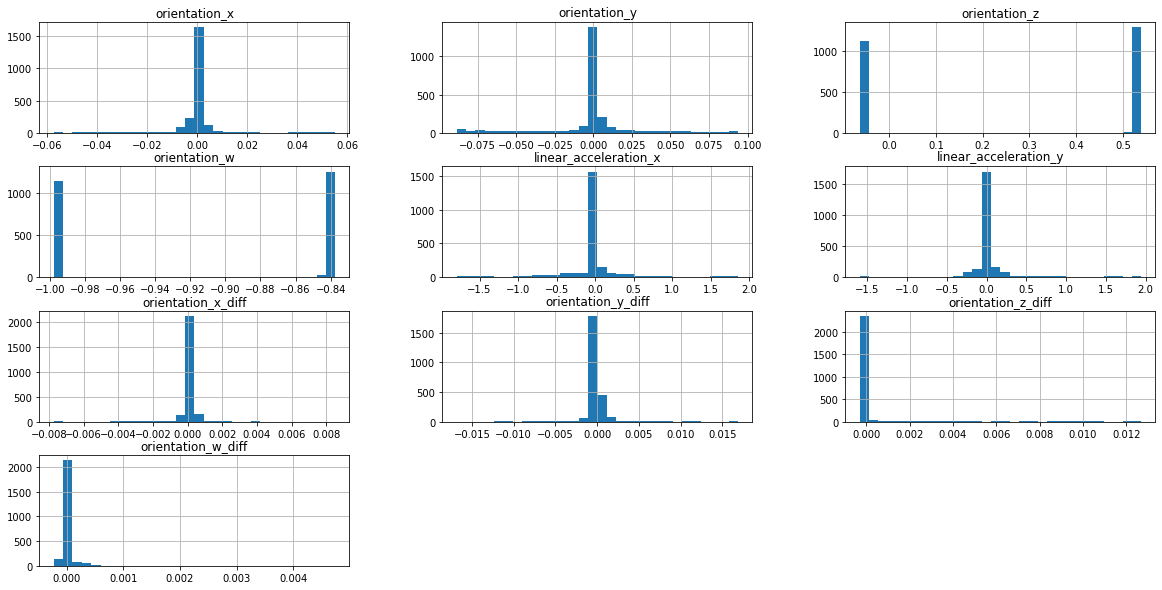

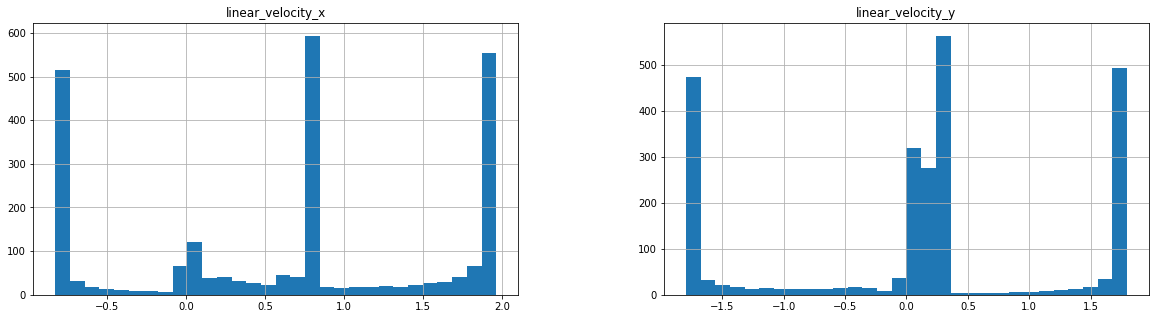

In [19]:
print("All Columns plot")
otuput = x_df.hist(figsize=(20,10), bins=30)
otuput = y_df.hist(figsize=(20,5), bins=30)

#Model creation and training 

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [20]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_dataset(INPUT_COLUMNS, OUTPUT_COLUMNS)

In [21]:
def create_ann_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount + len(ORIENTATION_SENSORS))),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(output_columns_amount, activation="linear")
    ])


    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.0005))
                    
    return model

def create_ann_tuned_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount)),
        layers.Dense(32, activation="sigmoid"),
        layers.Dense(output_columns_amount),
    ])
    

    learning_rate = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005,
        decay_steps=10000,
        decay_rate=0.9)

    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model

In [22]:
model = create_ann_model(len(INPUT_COLUMNS), len(OUTPUT_COLUMNS))

history = model.fit(train_x,
          train_y,
          epochs=100,
          batch_size=512,
          validation_data=(dev_x, dev_y))

2022-04-23 14:27:17.132744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 14:27:17.151516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 14:27:17.152350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 14:27:17.153593: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100
157/569 [=======>......................] - ETA: 0s - loss: 0.0794

2022-04-23 14:27:18.460163: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


569/569 [==============================] - 1s 1ms/step - loss: 0.0616 - val_loss: 0.0520
Epoch 2/100
569/569 [==============================] - 1s 986us/step - loss: 0.0428 - val_loss: 0.0360
Epoch 3/100
569/569 [==============================] - 1s 981us/step - loss: 0.0261 - val_loss: 0.0238
Epoch 4/100
569/569 [==============================] - 1s 979us/step - loss: 0.0174 - val_loss: 0.0206
Epoch 5/100
569/569 [==============================] - 1s 986us/step - loss: 0.0144 - val_loss: 0.0172
Epoch 6/100
569/569 [==============================] - 1s 982us/step - loss: 0.0130 - val_loss: 0.0159
Epoch 7/100
569/569 [==============================] - 1s 994us/step - loss: 0.0122 - val_loss: 0.0164
Epoch 8/100
569/569 [==============================] - 1s 1ms/step - loss: 0.0116 - val_loss: 0.0147
Epoch 9/100
569/569 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0144
Epoch 10/100
569/569 [==============================] - 1s 985us/step - loss: 0.0106 - val_

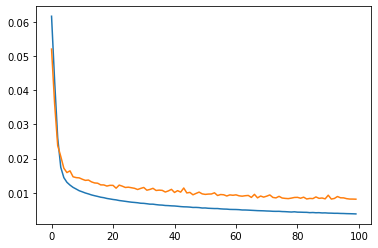

In [23]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

## Save model

In [ ]:
model_name = "o2s_temp"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

2022-04-22 22:35:41.603897: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://85e6edf6-01cc-4d09-ac5d-3c5e35d71478/assets


# Model tasting

In [24]:
def plot_model_prediction(real_xy_speed, pred_xy_speed):
    real_xy_speed = np.round(real_xy_speed, decimals=3)
    pred_xy_speed = np.round(pred_xy_speed, decimals=3)
    real_xy_speed_without_zeros = real_xy_speed.copy()
    real_xy_speed_without_zeros[real_xy_speed_without_zeros == 0] = 1
    approximation_error = (100 * (np.absolute(pred_xy_speed - real_xy_speed) / np.absolute(real_xy_speed_without_zeros)).mean(axis=0))[0]
    print(f"approximation_error: {approximation_error}")
    
    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 0].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 0].reshape(-1, 1))

    plt.show()

    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 1].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 1].reshape(-1, 1))

    plt.show()

In [36]:
def test_model_prediction(model: tf.keras.Model,
                          scaler_x: MinMaxScaler,
                          scaler_y: MinMaxScaler, 
                          record_file_name: str) -> None:
  recording_path = os.path.join(DATA_FOLDER_PATH, record_file_name)
  x_df, real_xy_speed = load_flight_steps_from_file(recording_path, INPUT_COLUMNS, OUTPUT_COLUMNS)
  real_xy_speed = real_xy_speed.to_numpy()

  data_x = scaler_x.transform(x_df)
  pred_y = model.predict(data_x)
  pred_xy_speed = scaler_y.inverse_transform(pred_y)
  # pred_xy_speed = pd.DataFrame(pred_xy_speed).ewm(span=30, adjust=False).mean().to_numpy()

  plot_model_prediction(real_xy_speed, pred_xy_speed)

approximation_error: 953.1352237085725


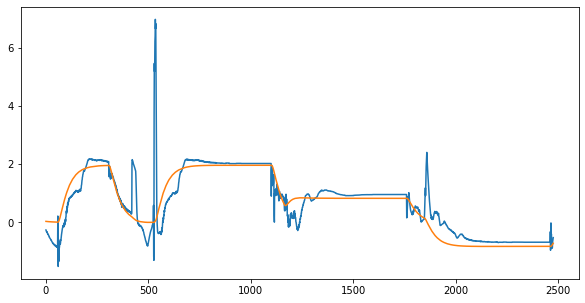

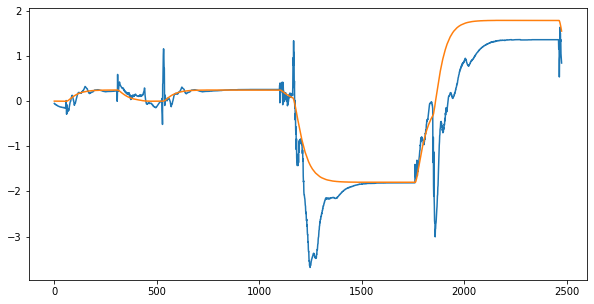

In [37]:
record_file_name = "manual_2022:04:22_20:38:48_record.csv"   
test_model_prediction(model, scaler_x, scaler_y, record_file_name)   

approximation_error: 278.0408088891751


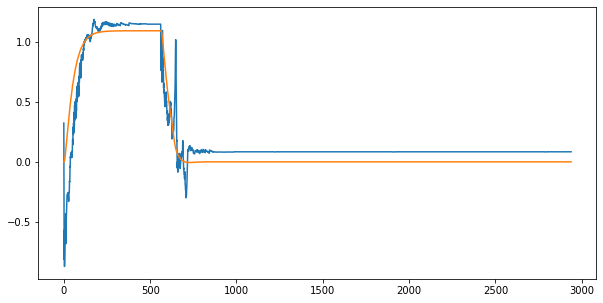

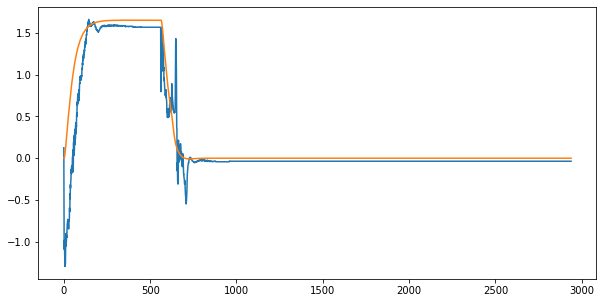

approximation_error: 885.7518269201396


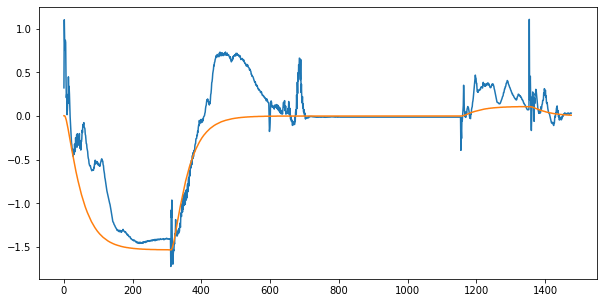

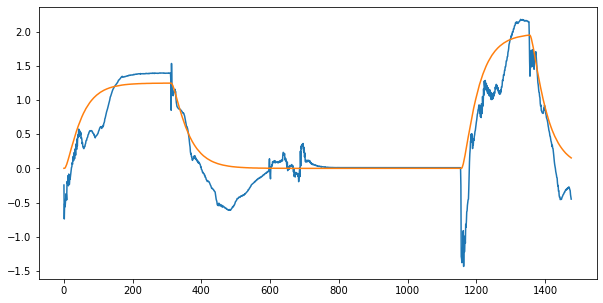

approximation_error: 125.37395698858404


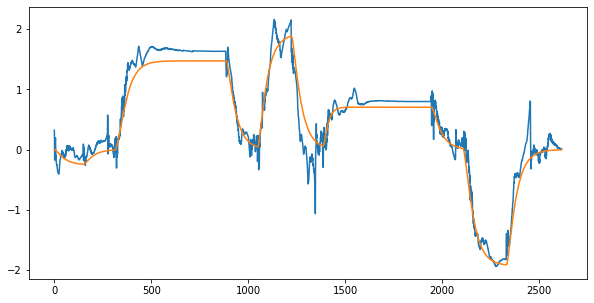

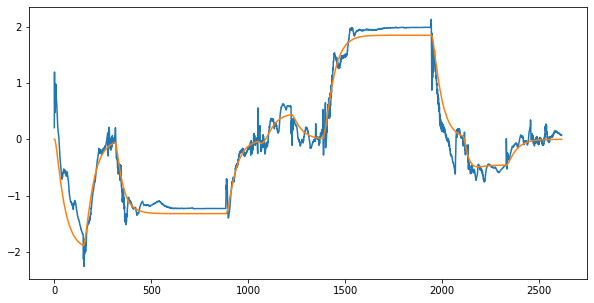

approximation_error: 112.88570446703781


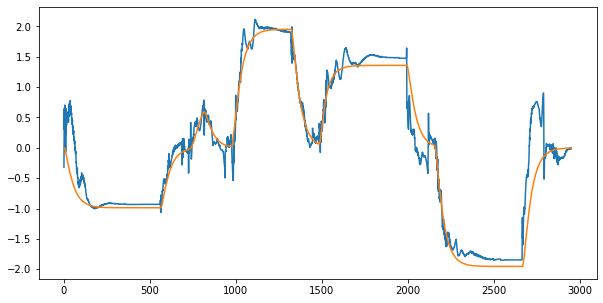

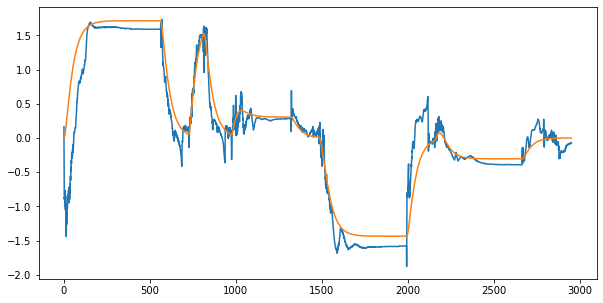

approximation_error: 1610.7936628752548


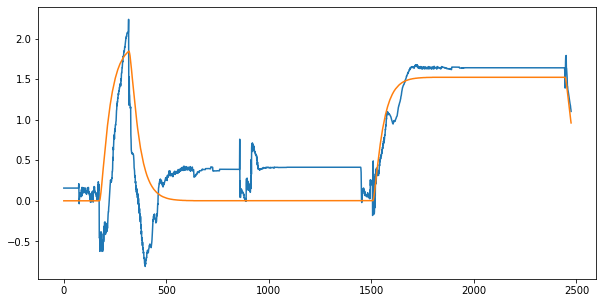

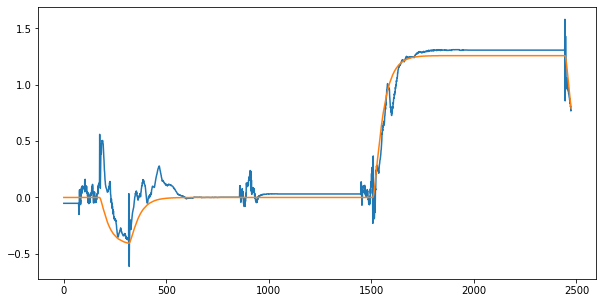

approximation_error: 108.35809686471623


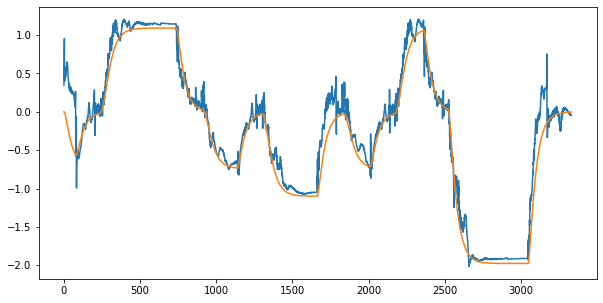

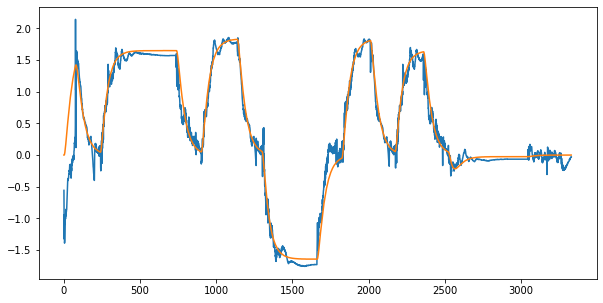

approximation_error: 2531.9336176103134


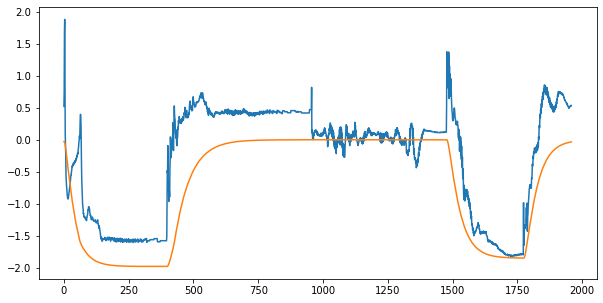

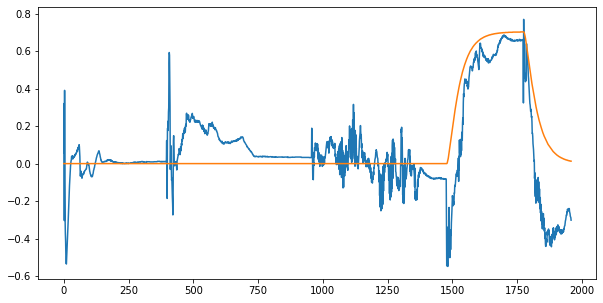

approximation_error: 417.9994764066252


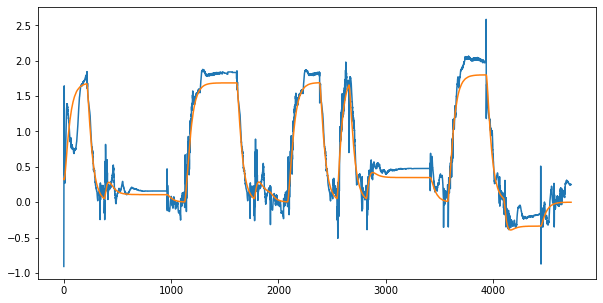

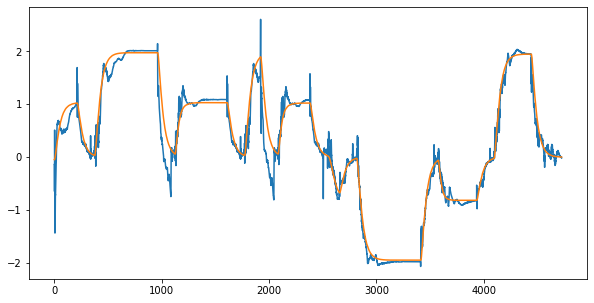

approximation_error: 526.9984750486445


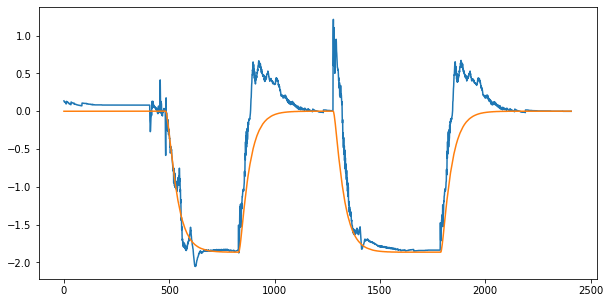

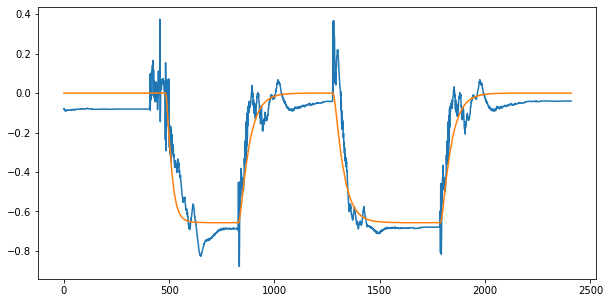

approximation_error: 149.01894251030836


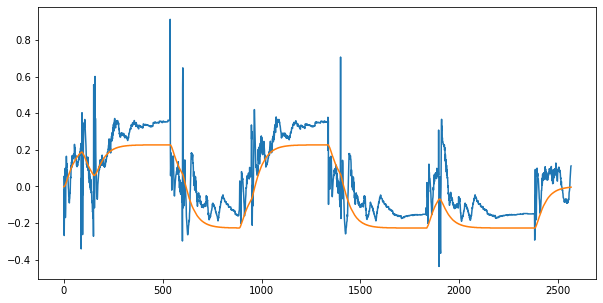

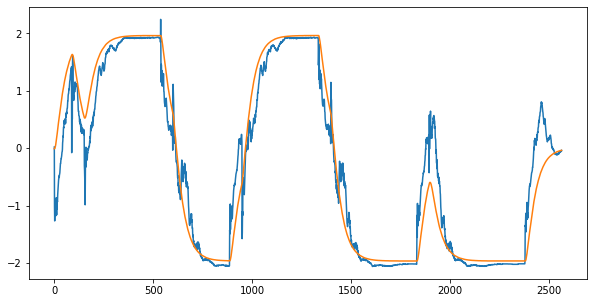

approximation_error: 536.4424878743188


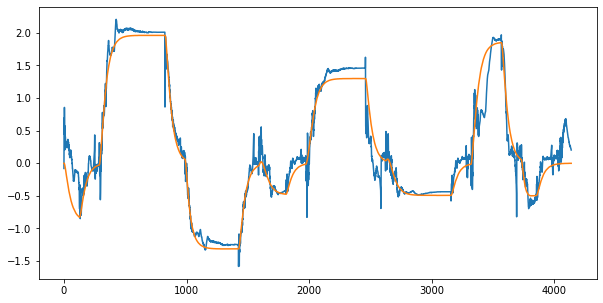

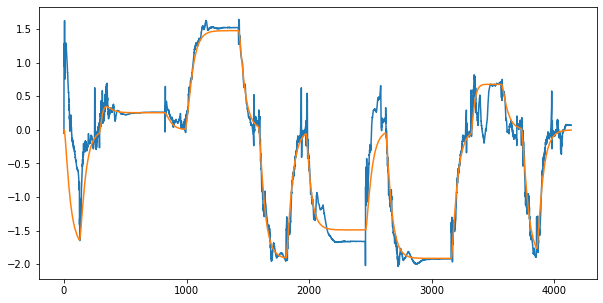

approximation_error: 150.35861252868648


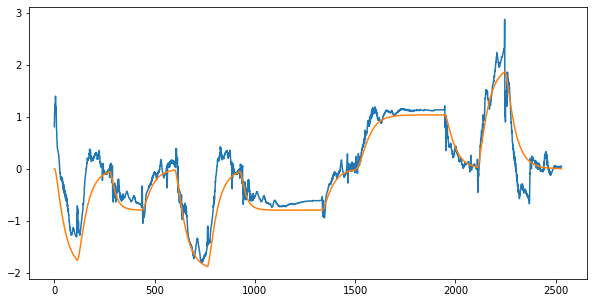

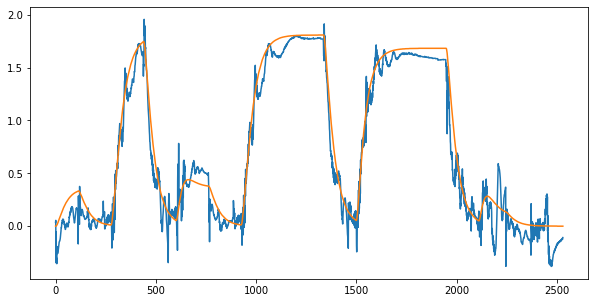

approximation_error: 62.49381102971623


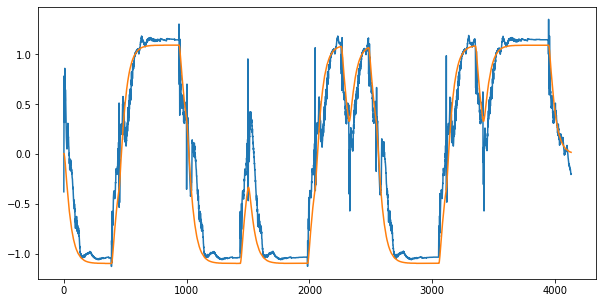

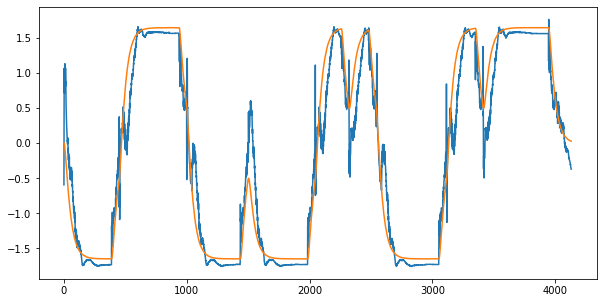

approximation_error: 235.6663605485693


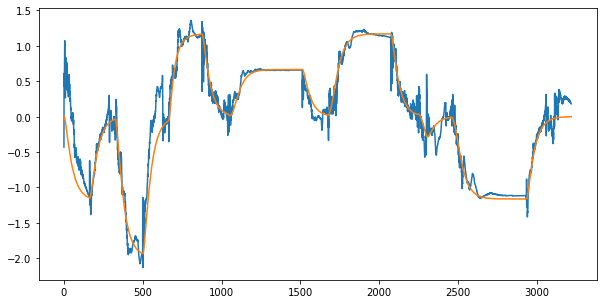

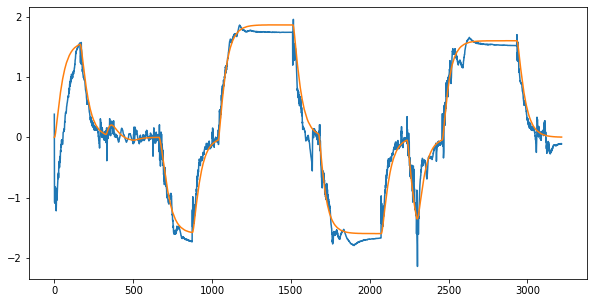

approximation_error: 55.65570417834576


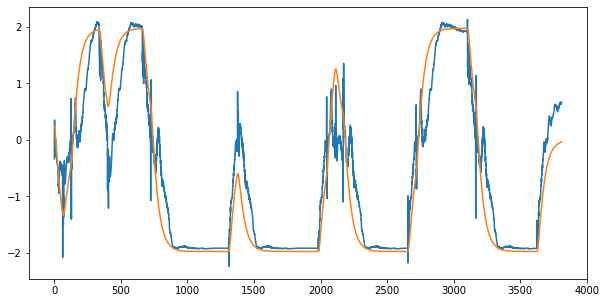

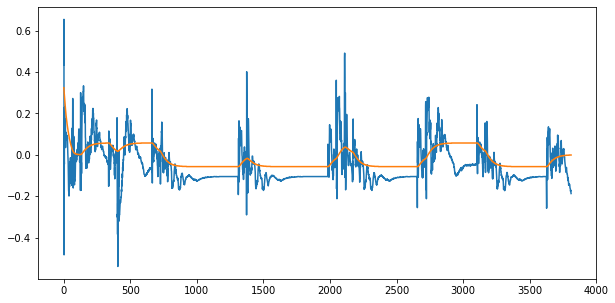

approximation_error: 257.69892426600956


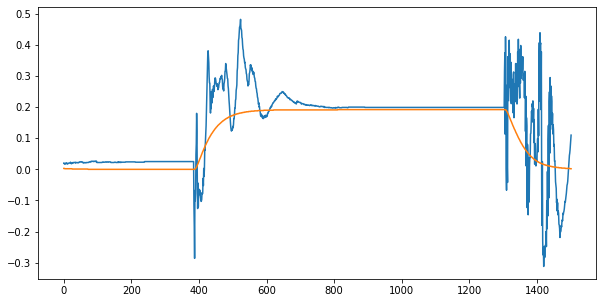

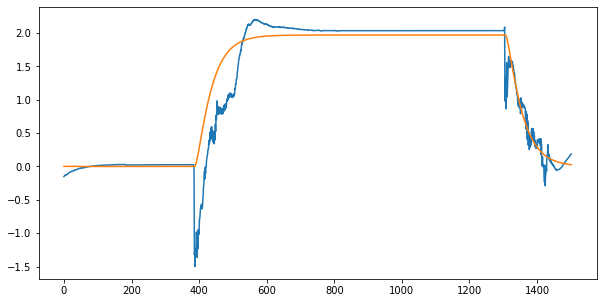

approximation_error: 128.14036698884402


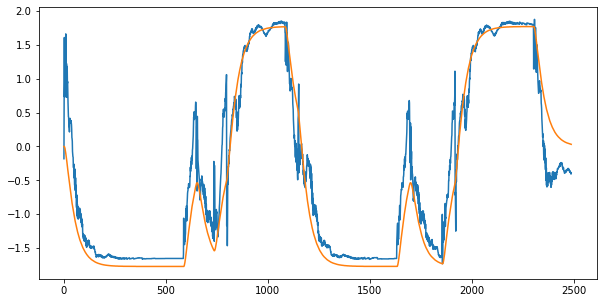

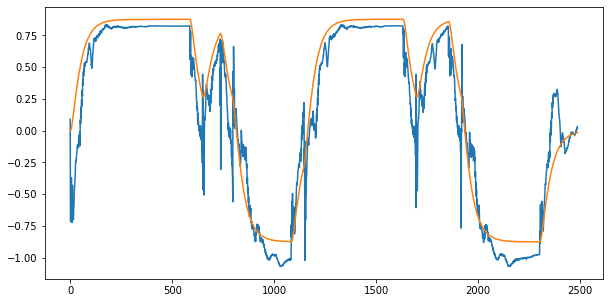

approximation_error: 91.9466128438446


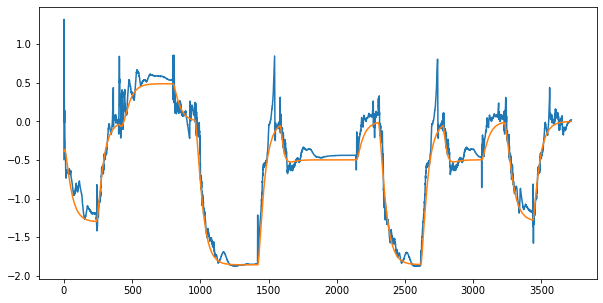

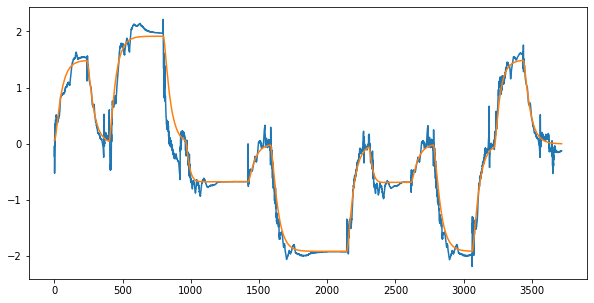

approximation_error: 234.37630731556615


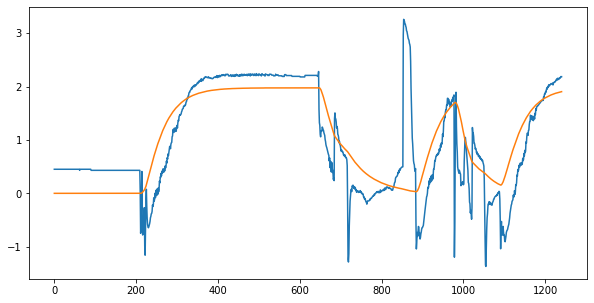

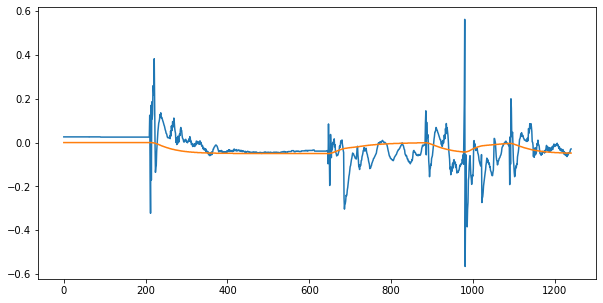

approximation_error: 135.73448645304867


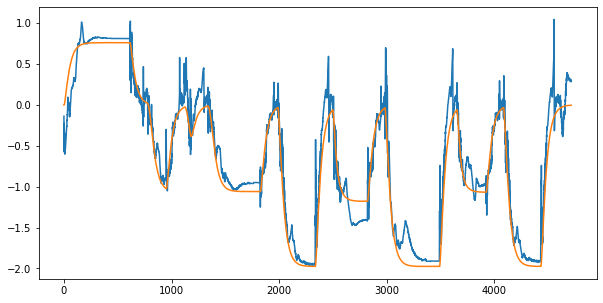

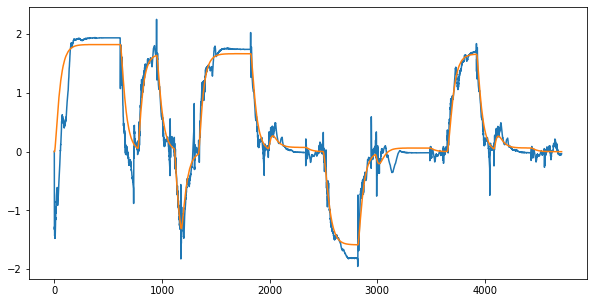

approximation_error: 129.16046781194302


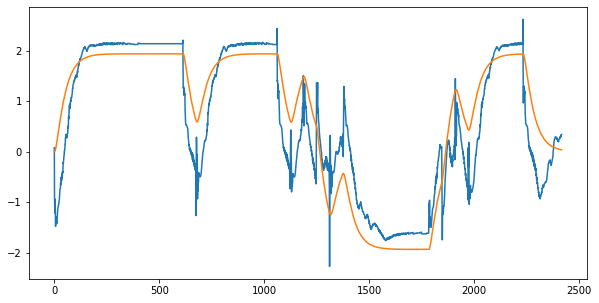

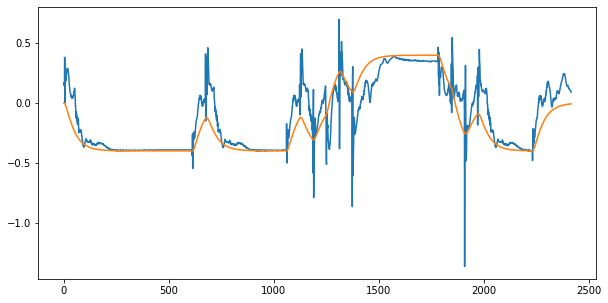

approximation_error: 96.15669362103615


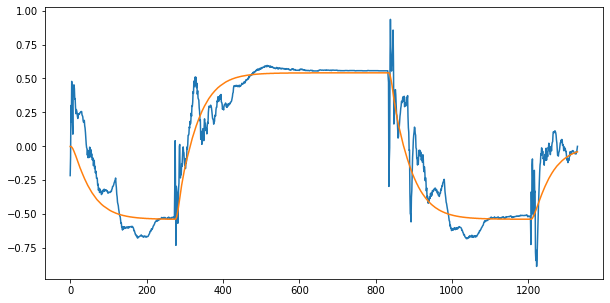

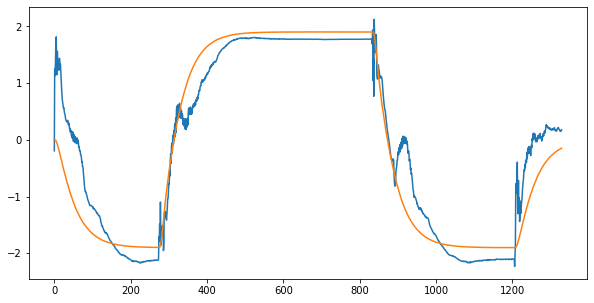

approximation_error: 72.2999981486523


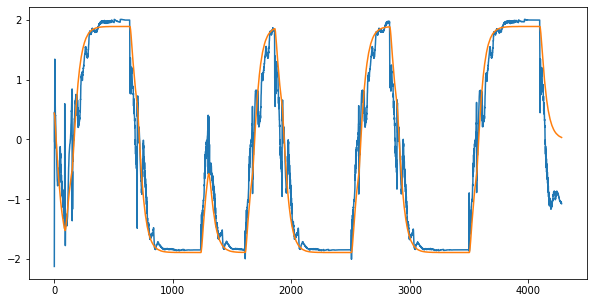

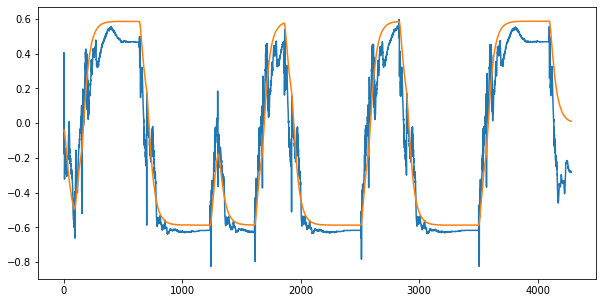

approximation_error: 152.10208207232944


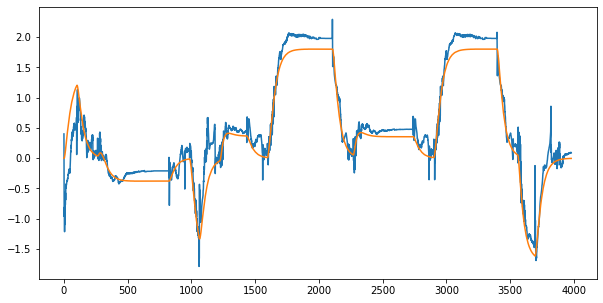

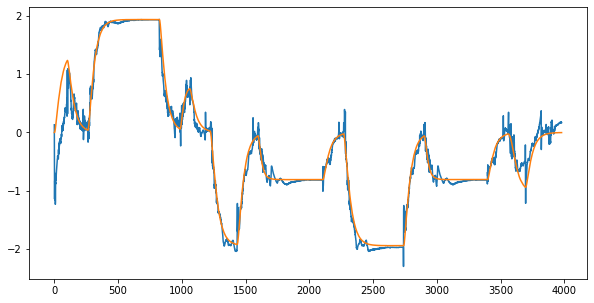

approximation_error: 1249.858853698061


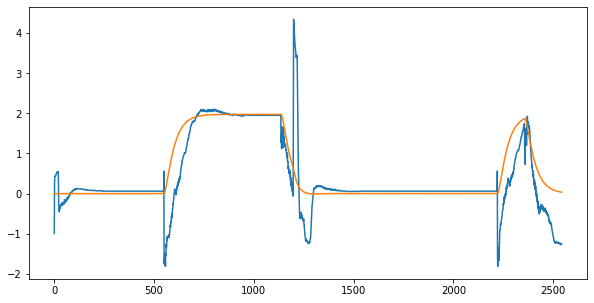

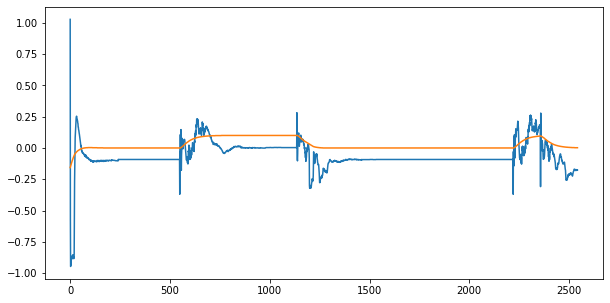

approximation_error: 82.81803660522922


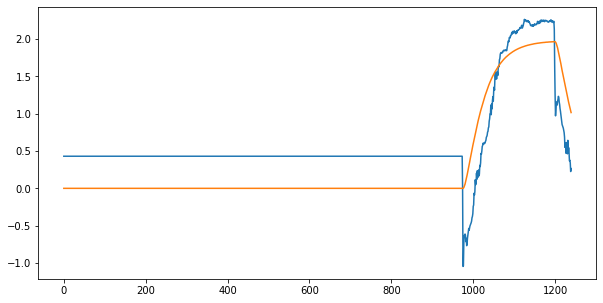

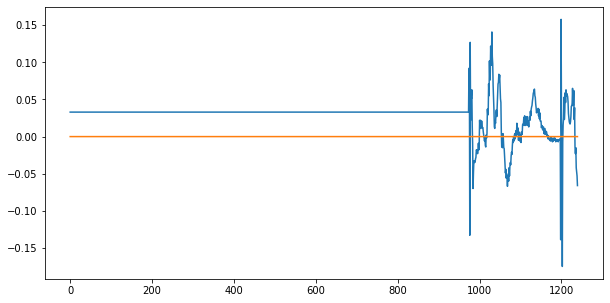

approximation_error: 2721.4055385051365


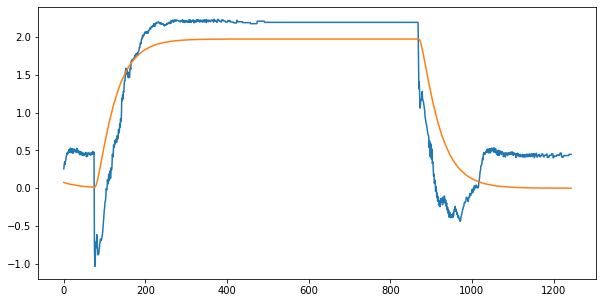

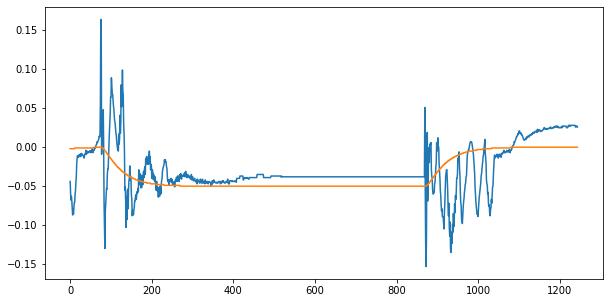

approximation_error: 300.6246348650944


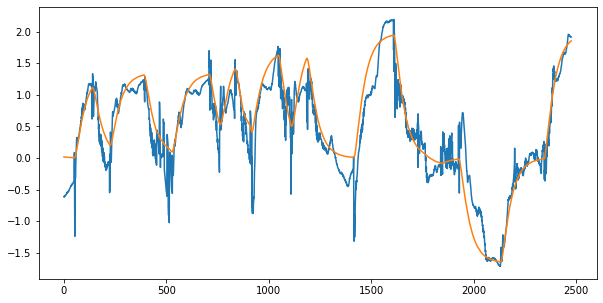

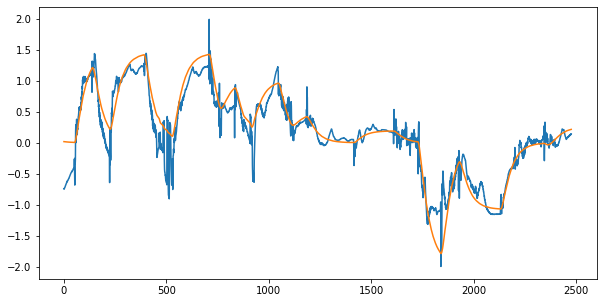

approximation_error: 616.0255963624552


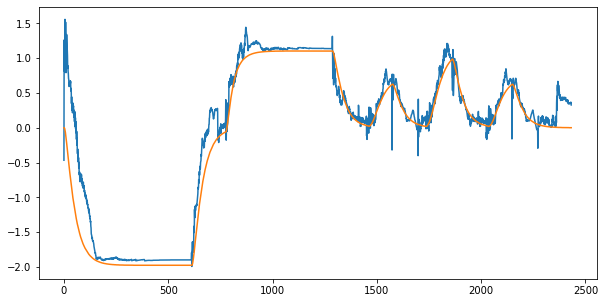

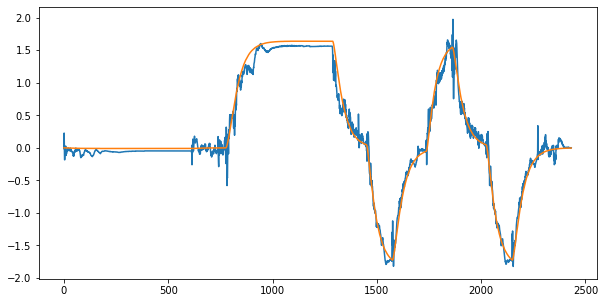

approximation_error: 181.41767781515523


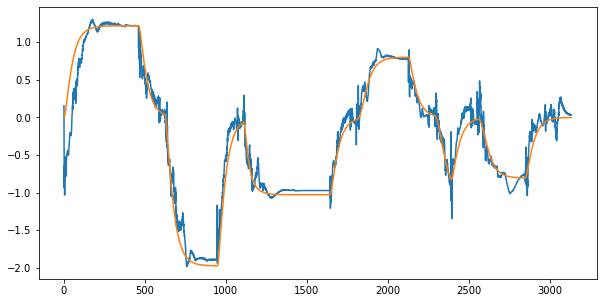

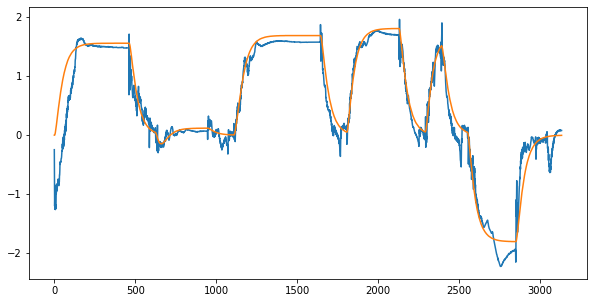

approximation_error: 1282.4375628140097


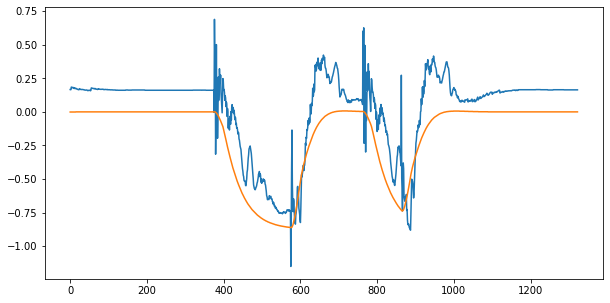

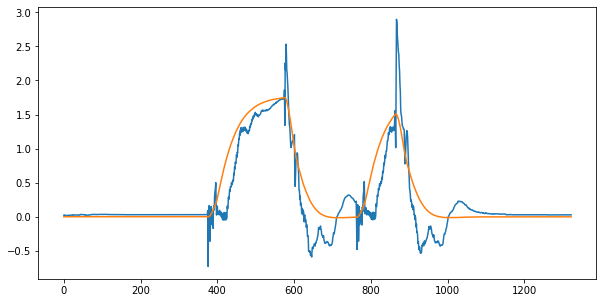

approximation_error: 91.9289045912396


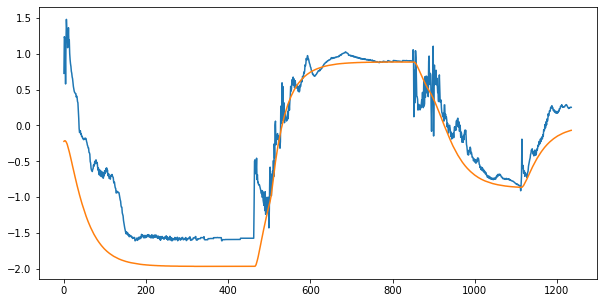

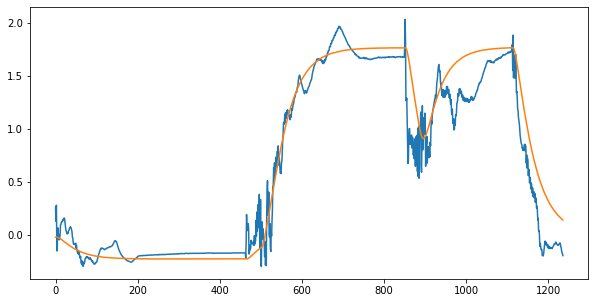

approximation_error: 114.88466183345172


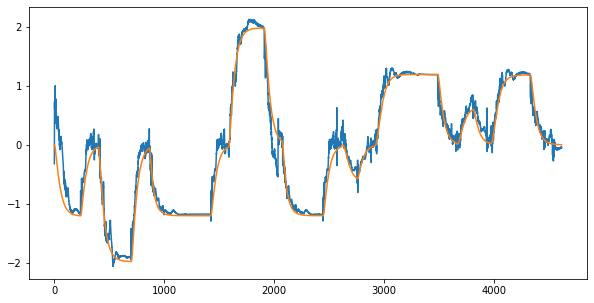

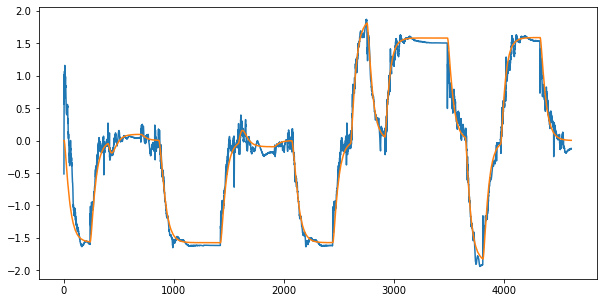

approximation_error: 219.8974268190835


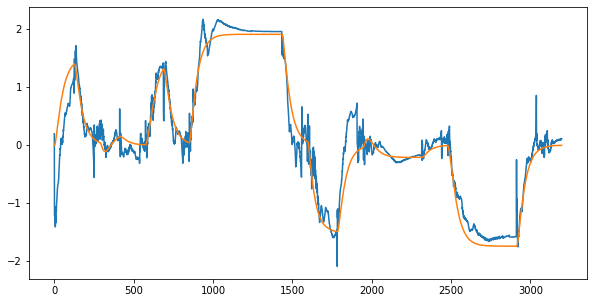

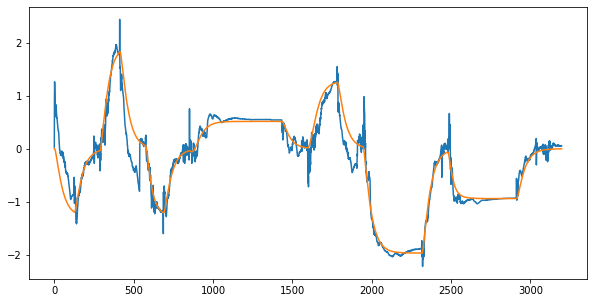

approximation_error: 129.25987212559454


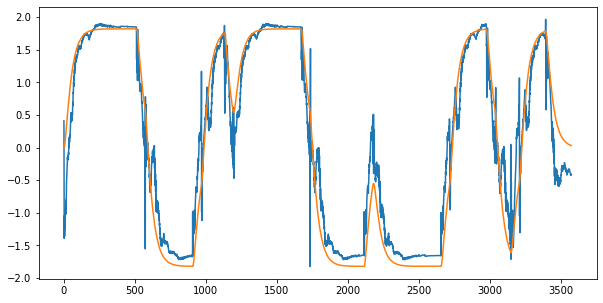

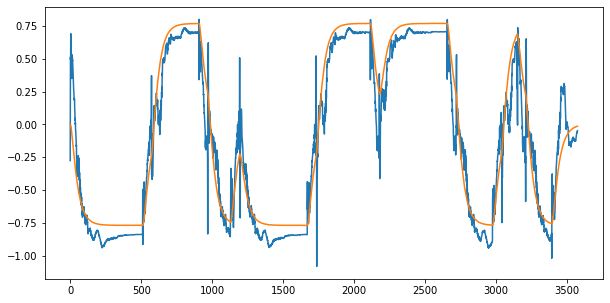

approximation_error: 477.54947522360095


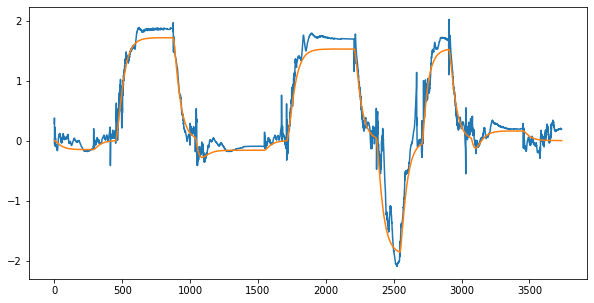

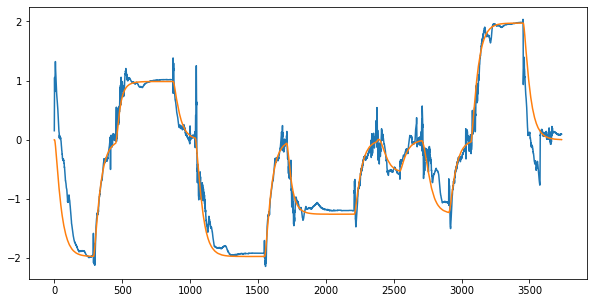

approximation_error: 121.0750409901336


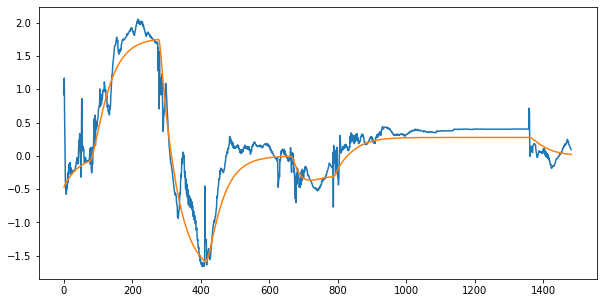

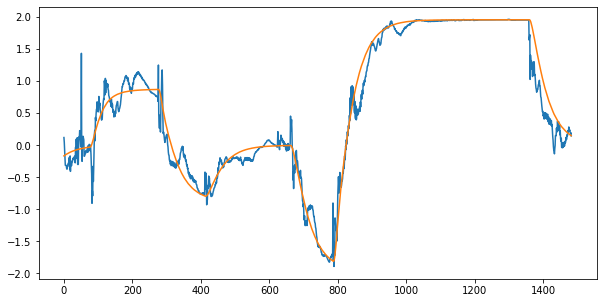

approximation_error: 519.0097097200188


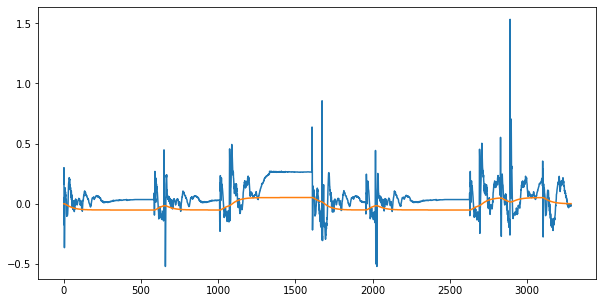

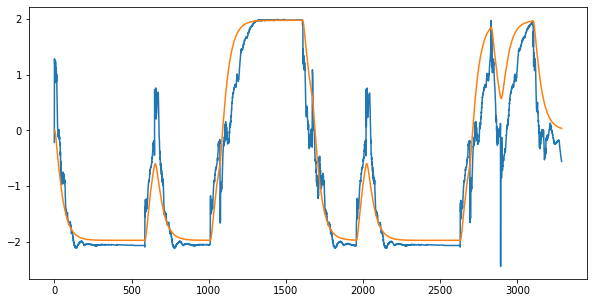

approximation_error: 120.89553549156862


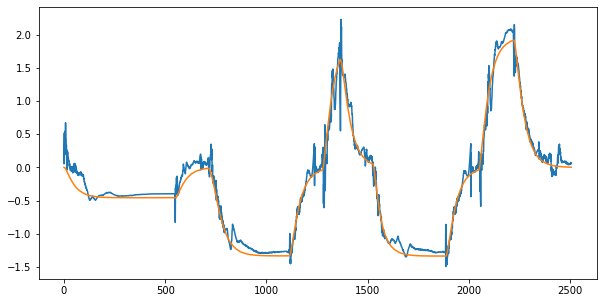

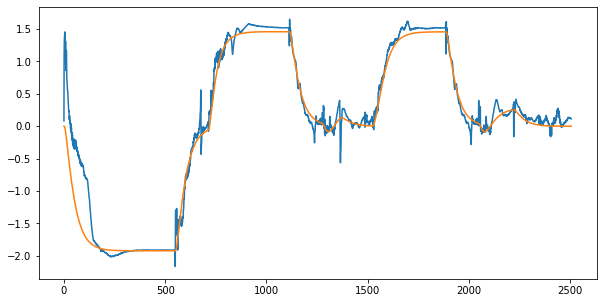

approximation_error: 61.95352790301556


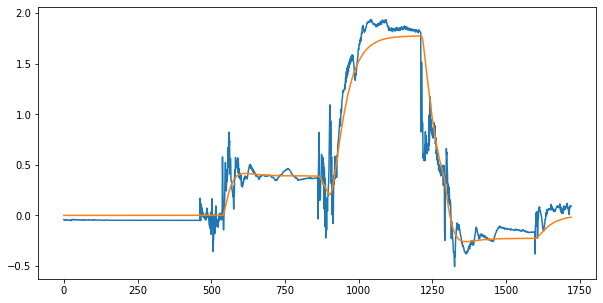

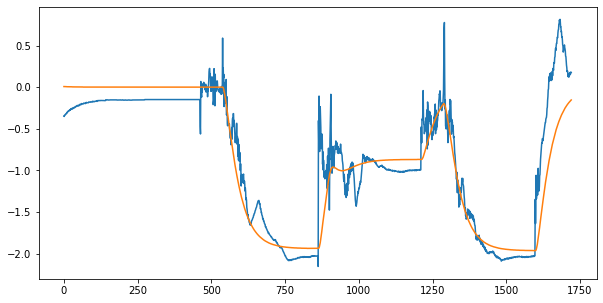

approximation_error: 573.6624902165184


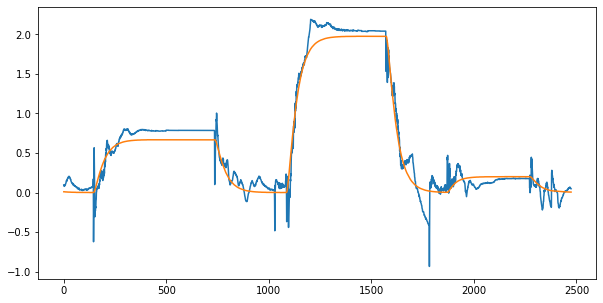

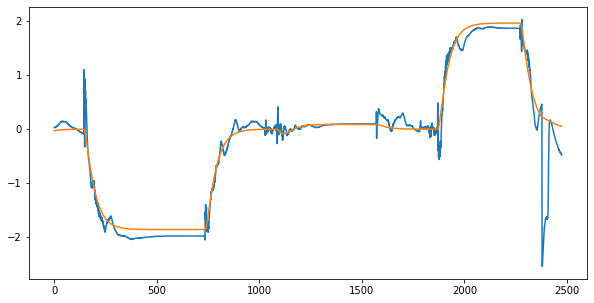

approximation_error: 372.39172803647824


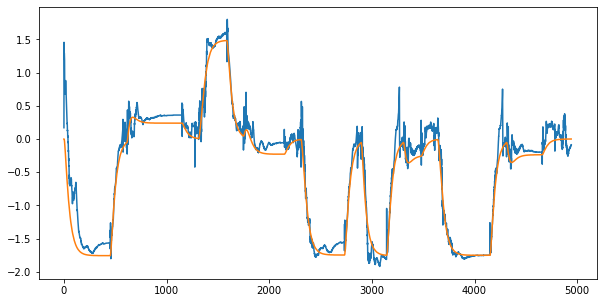

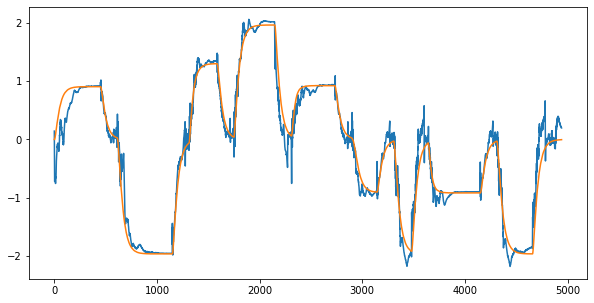

approximation_error: 216.27724860055974


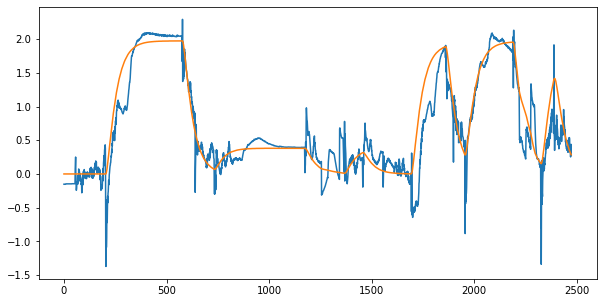

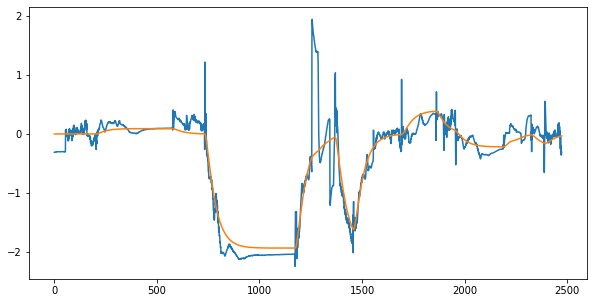

approximation_error: 139.13665287782013


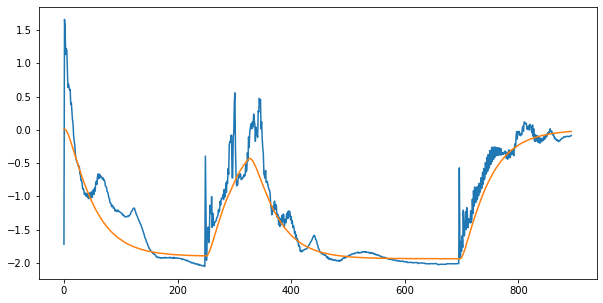

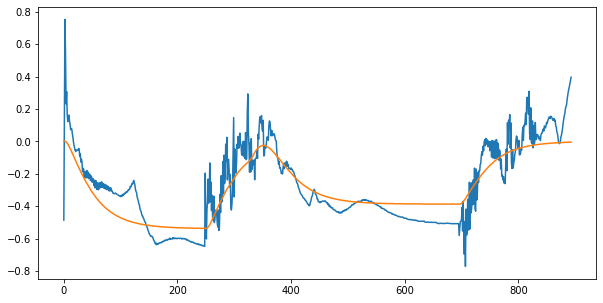

approximation_error: 147.22231662372815


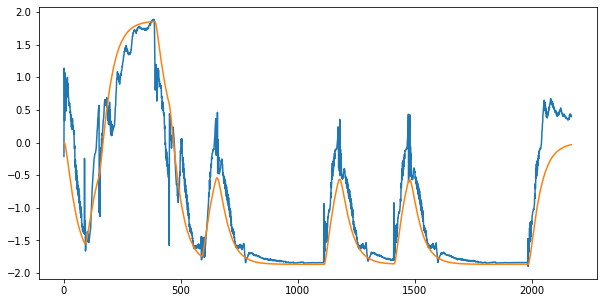

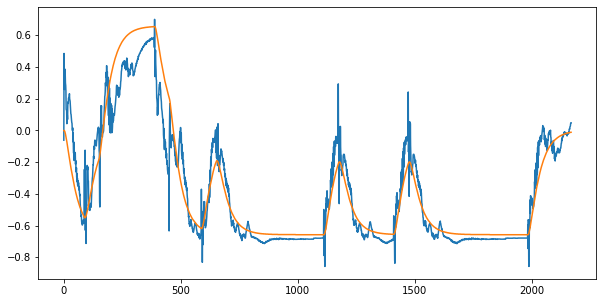

approximation_error: 206.7062399660501


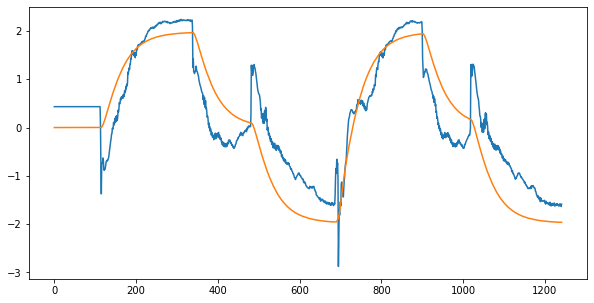

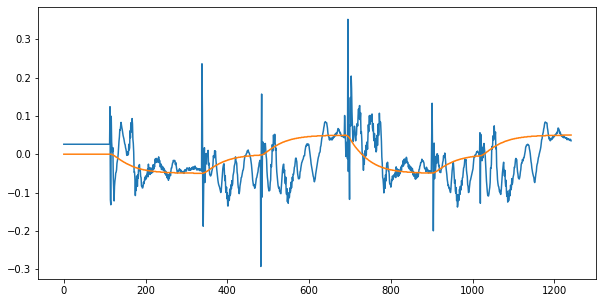

approximation_error: 455.11742561126897


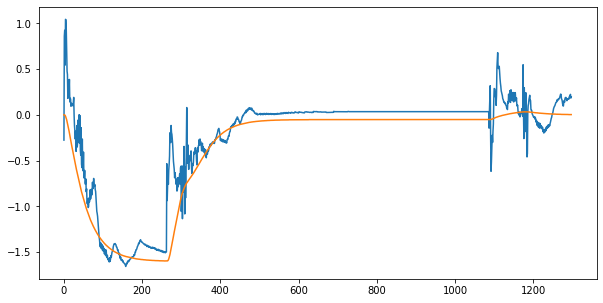

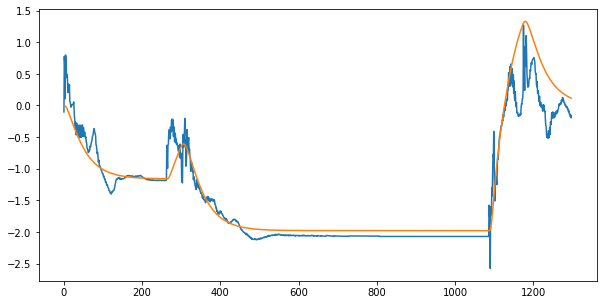

approximation_error: 88.05788280498527


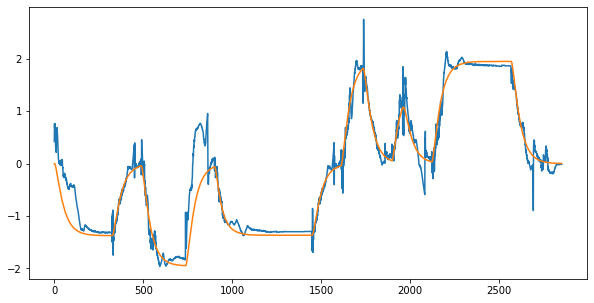

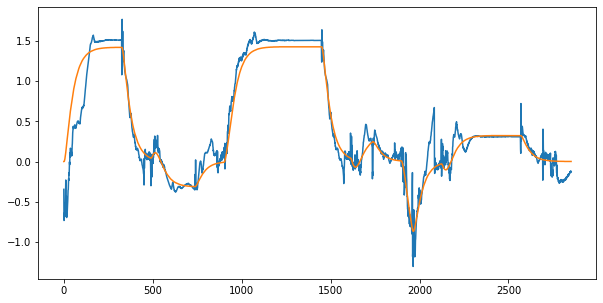

approximation_error: 106.39496453757926


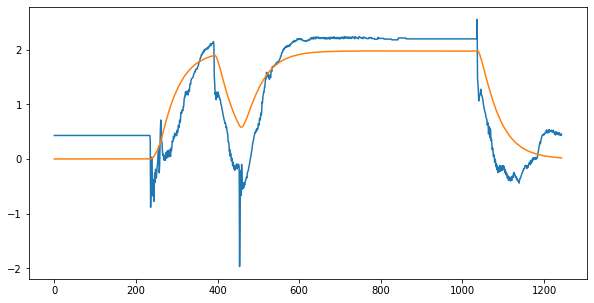

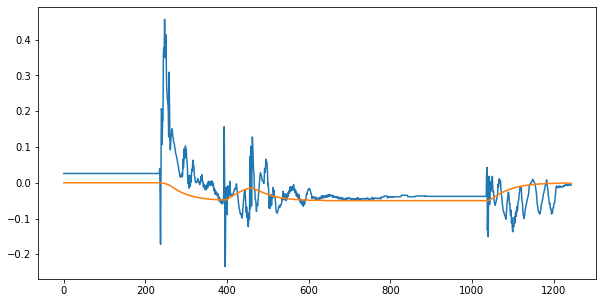

approximation_error: 134.92520652601996


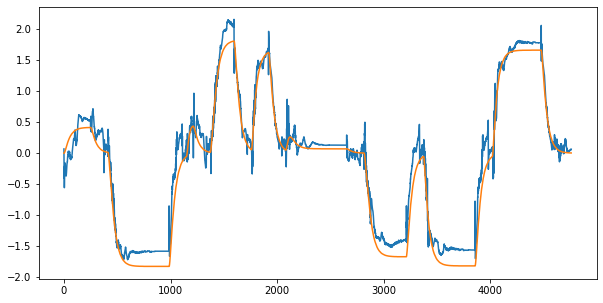

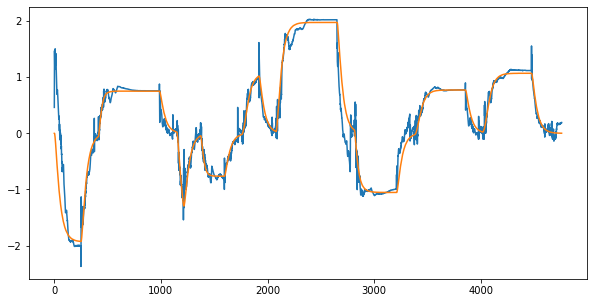

approximation_error: 117.6141729471108


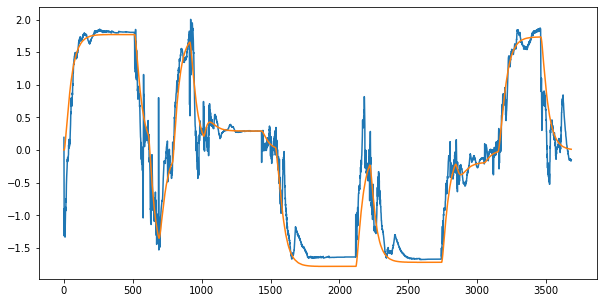

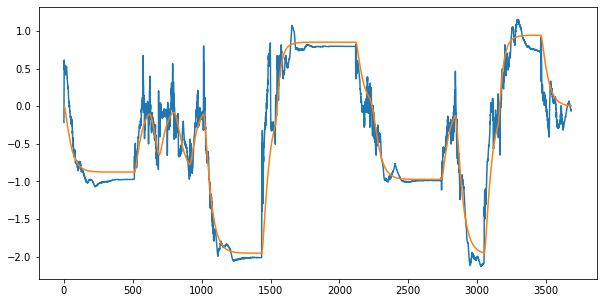

approximation_error: 1862.5134193863378


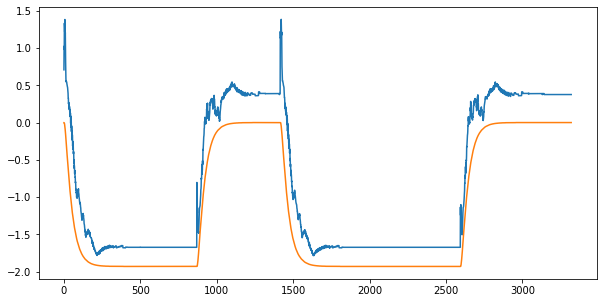

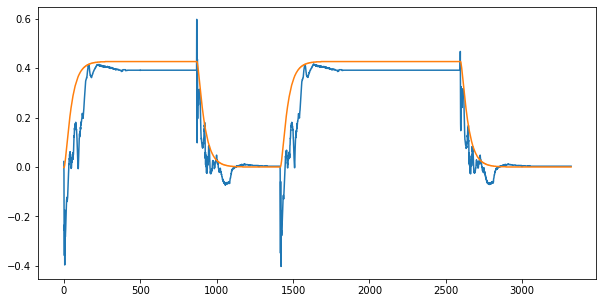

approximation_error: 3771.491611172818


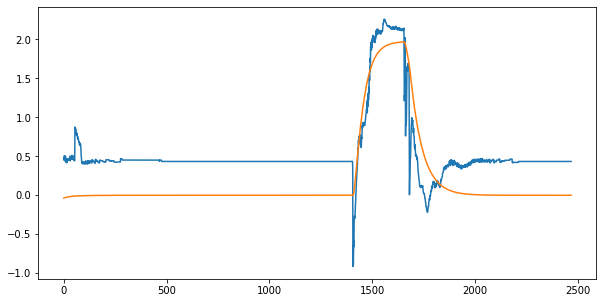

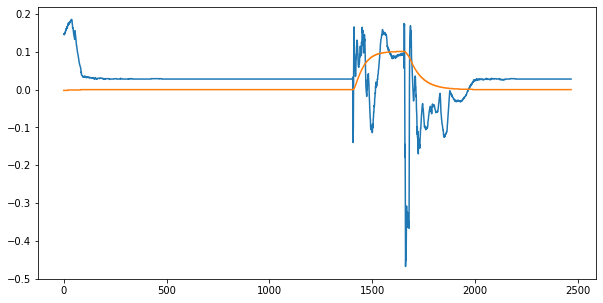

approximation_error: 46.51286746862457


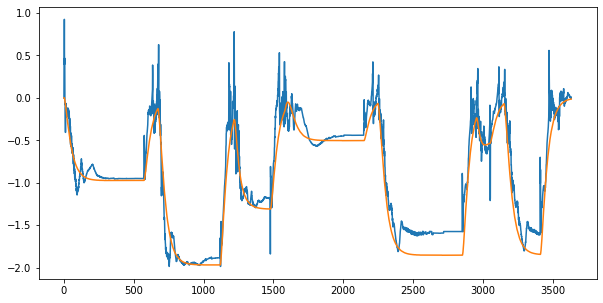

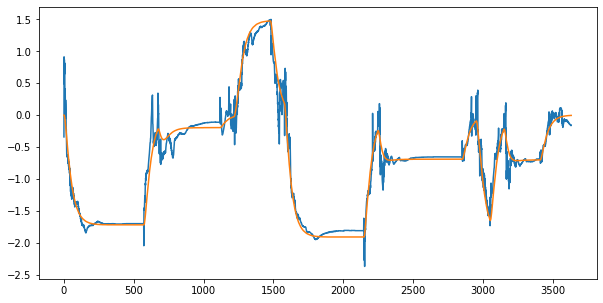

approximation_error: 203.99466984941097


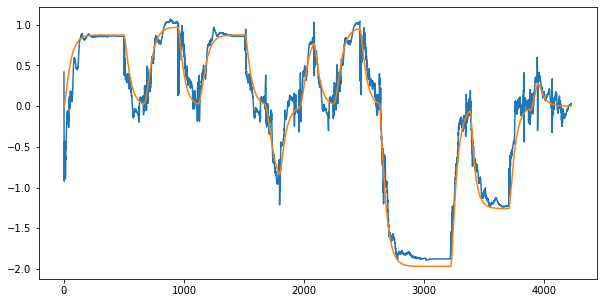

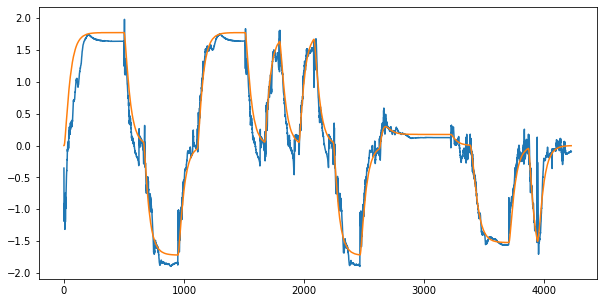

approximation_error: 326.83281858864433


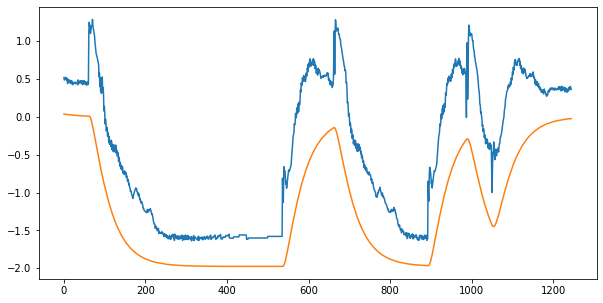

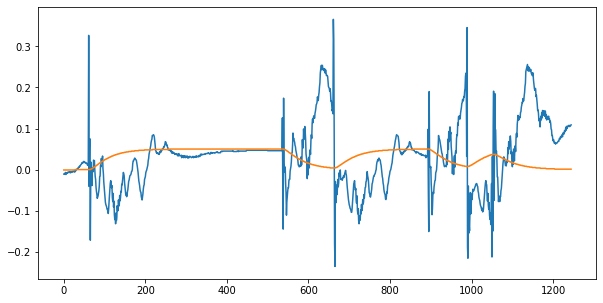

approximation_error: 2301.5370204098294


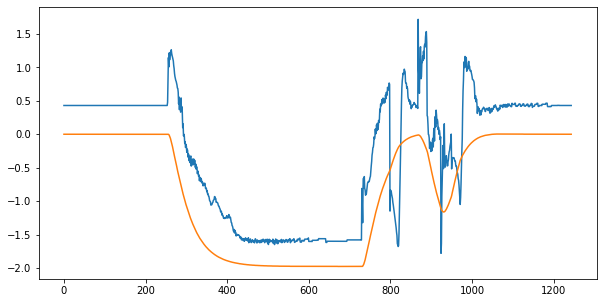

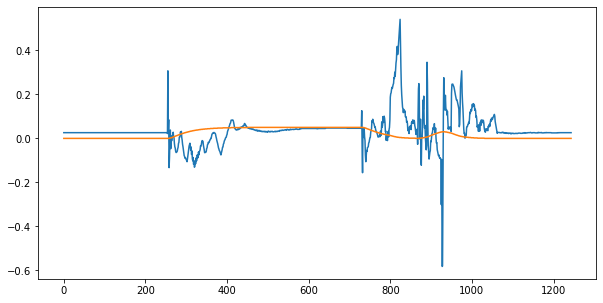

approximation_error: 265.3187318227028


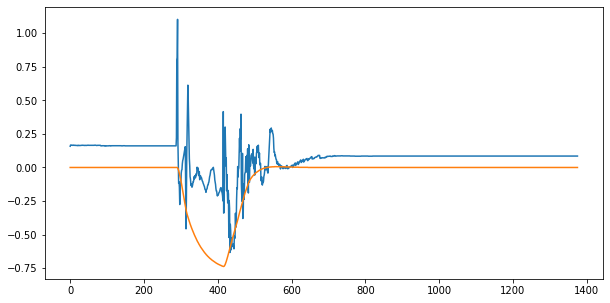

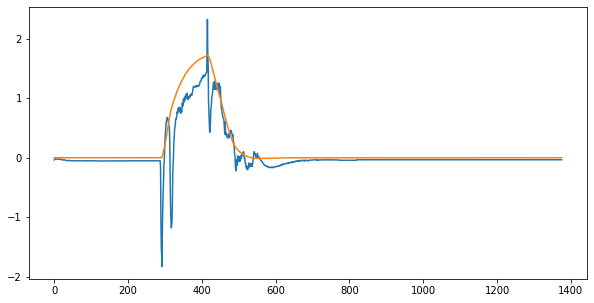

approximation_error: 142.84656200299554


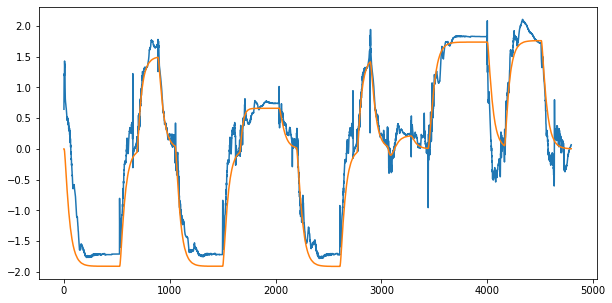

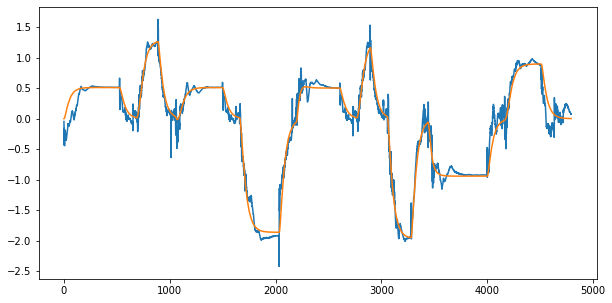

approximation_error: 827.0717754290507


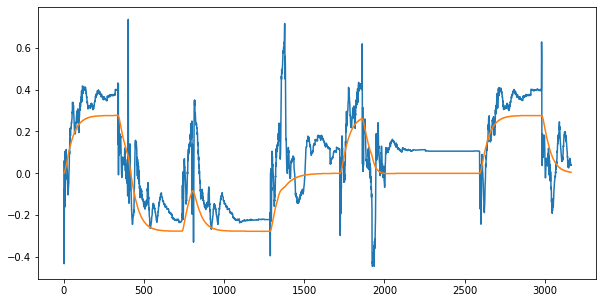

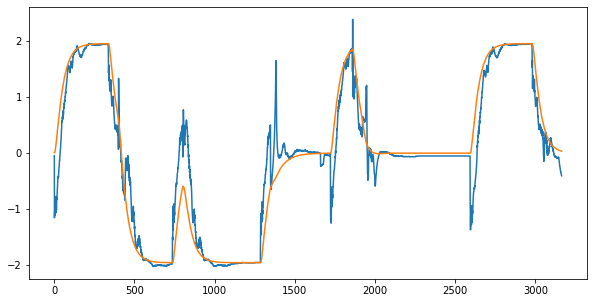

approximation_error: 953.1352237085725


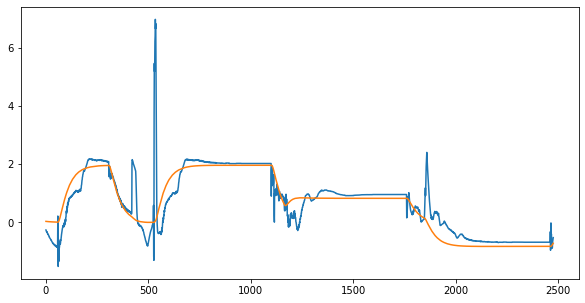

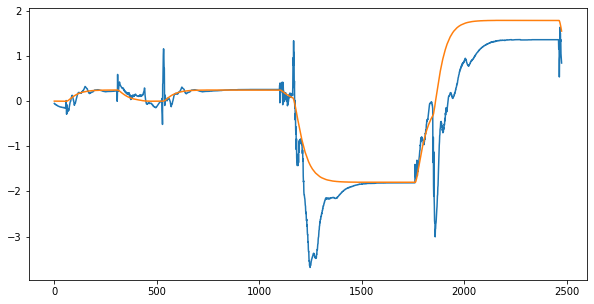

In [38]:
for record_file_name in get_recordings_files()[::2]:
  test_model_prediction(model, scaler_x, scaler_y, record_file_name) 

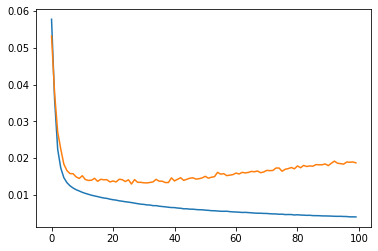

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

# Hyperparameters tuning

### Model Creation

In [ ]:
def create_dynamic_model(hp: kt.HyperParameters) -> Model:
    """
    Creates Sequence model dynamically
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()
    model.add(layers.Input(shape=(hp.get("input_columns_amount"))))    

    dense_layers = hp.Int("dense_layers", min_value=1, max_value=1)
    for layer_id in range(dense_layers):
      layer_units = hp.Int(f"dense_{layer_id}_units", min_value=4, max_value=32)

      activation = hp.Choice("activation", values=["tanh", "sigmoid", "relu"])
      model.add(layers.Dense(layer_units, activation=activation))

      if hp.Boolean(f"dense_{layer_id}_dropout_status"):
          dropout_rate = hp.Float(f"dense_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
          model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hp.get("output_columns_amount"), activation="sigmoid"))

    learning_rate = hp.Choice("adam_learning_rate", [0.1, 0.05, 1e-2, 1e-3, 5e-3, 5e-4])

    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)

    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model



### The Tuner



In [ ]:
hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_COLUMNS))

project_name = "ann_18AprDay_speed8"
tuner = kt.BayesianOptimization(
    create_dynamic_model,
    hyperparameters=hp,
    objective="val_loss",
    max_trials=2000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
    executions_per_trial = 1
)

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'input_columns_amount': 4,
 'output_columns_amount': 2,
 'dense_layers': 2,
 'dense_0_units': 16,
 'dense_0_dropout_status': True,
 'adam_learning_rate': 0.005,
 'learning_rate_decay': False,
 'dense_0_dropout_rate': 0.05,
 'dense_1_units': 44,
 'dense_1_dropout_status': True,
 'dense_2_units': 8,
 'dense_2_dropout_status': True,
 'dense_1_dropout_rate': 0.0}

In [ ]:
model = tuner.get_best_models()[0]
model_name = "speed_best_12Mar_10"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

### Truning

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, baseline=0.08)

tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 200,
             batch_size=512,
             callbacks=[early_stop, tensorboard_callback])



Trial 3 Complete [00h 00m 03s]
val_loss: 0.15008710324764252

Best val_loss So Far: 0.10004942864179611
Total elapsed time: 00h 00m 09s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
input_columns_a...|4                 |4                 
output_columns_...|2                 |2                 
dense_layers      |1                 |1                 
dense_0_units     |4                 |20                
activation        |relu              |relu              
dense_0_dropout...|True              |True              
adam_learning_rate|0.1               |0.05              
learning_rate_d...|False             |False             
dense_0_dropout...|0                 |0                 

Epoch 1/200
  1/554 [..............................] - ETA: 1:09 - loss: 0.1828WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0005s vs `on_train_batch_end` time: 0.0008s). Check your callbacks.


KeyboardInterrupt: ignored